In [ ]:
import Pkg; Pkg.add(["Plots","Interact","SparseArrays","FFTW"]);
import Logging; Logging.disable_logging(Logging.Info)

In [2]:
const STATIC_LECTURE = false;

In [3]:
using LinearAlgebra;
using Plots; gr(); default(l=5, label=false);
using Printf;
using Interact;
using SparseArrays;

BLAS.set_num_threads(1)

if STATIC_LECTURE
    default(fmt=:png)
    macro manipulate(v)
        return :($v; plot!())
    end
end

prettyprint(a) = map(x -> @sprintf("%+.2f", x), a)
sciprint(a) = map(x -> @sprintf("%+.2e", x), a)

function imshow(x; kwargs...)
    return heatmap(x
        , aspect_ratio=:equal
        , framestyle=:none
        , yflip=true
        , c=cgrad(:diverging_gwv_55_95_c39_n256, rev=true)
        ; kwargs...
    )
end
function imshowlog(x; kwargs...)
    return heatmap(max.(log.(abs.(x)), log(eps()))
        , aspect_ratio=:equal
        , framestyle=:none
        , yflip=true
        , c=cgrad(:linear_worb_100_25_c53_n256)
        ; kwargs...
    )
end
bigspy(x; kwargs...) = spy(x, m=4, c=:diverging_gwv_55_95_c39_n256; kwargs...)
p = plot!([0,1],[0,1]);

WebIO._IJuliaInit()

### Warmup

Consider the **High performance Linpack benchmark:** timing LU factorization with partial pivoting:

- Current best: [Fugaku supercomputer](https://top500.org/system/179807/) sustains $4 \times 10^{17}$ flops/s on this problem...

- ...for a problem of size $m = 2 \times 10^7$

How long did it take Fugaku to compute the LU factorization?

# Introduction to Iterative Methods

## Beyond Dense Linear Algebra

### All semester we have analyzed algorithms for factorizations

| name | complexity |
| :-----: | :-----: |
| Householder $QR$ | ${\sim 2mn^2 - \frac{2}{3}n^3}$ |
| $LU$             | ${\sim \frac{2}{3} m^3}$ |
| Cholesky $LL^*$ | ${\sim \frac{1}{3} m^3}$ |
| Eigenvalue (hermitian) $Q \Lambda Q^*$ | ${\sim \frac{4}{3}m^3 + O(m^3)}$ |
| Schur $Q T Q^*$ | ${\sim \frac{10}{3}m^3 + O(m^3)}$ |
| SVD $U \Sigma V^*$ | ${\sim 4mn^2 - \frac{4}{3}n^3 + O(n^3)}$ |

- All of these algorithms assume the matrix is stored as a dense array

- If $n = O(m)$ all of these factorizations are $O(m^3)$

### $O(m^3)$ is prohibitive for large problems

As the warmup shows, the worlds fastest computer can solve $Ax = b$ by LU factorization for $m = 2 \times 10^7$ in $O(\text{hours})$.

Baker, Falgout, Kolev, Yang **(2012)**. _Scaling hypre's multigrid solvers to 100,000 cores_. [doi:10.1007/978-1-4471-2437-5_13](https://doi.org/10.1007/978-1-4471-2437-5_13).  Solving $Ax = b$ where $A$ is a discretized PDE operator for $m = 10^{12}$ in $O(\text{minutes})$.

### [Edelman's law](https://doi.org/10.1177/109434209300700203)

> [N]ature is not so perverse as to throw $n^2$ numbers at us haphazardly. Therefore, when faced with large $n$-by-$n$ matrices, we ought to try our hardest to take advantage of the structure that is surely there.

### Simplest improvement: sparse direct linear algebra

Do the same numerical operations as dense linear algebra, but avoid storing and computing zeros.

(Except sometimes orderings are chosen to promote sparsity)

### Sparse Linear Algebra Libraries

(There is not an agreed upon interface to the same extent there is for dense linear algebra)

- [SuiteSparse](https://people.engr.tamu.edu/davis/suitesparse.html)

- [SuperLU](https://portal.nersc.gov/project/sparse/superlu/)

- [MUMPS](http://mumps.enseeiht.fr/)

- [Pastix](https://ramet.github.io/project/pastix6/)

- [Pardiso](https://www.pardiso-project.org/)

- [cuSPARSE](https://docs.nvidia.com/cuda/cusparse/index.html)

- [Kokkos kernels](https://github.com/kokkos/kokkos-kernels)

### Example: a discrete Laplacian $L_d$

Represents the PDE $u_{xx} = f$ (1D), $u_{xx} + u_{yy} = f$ (2D), or $u_{xx} + u_{yy} + u_{zz} = f$ (3D)

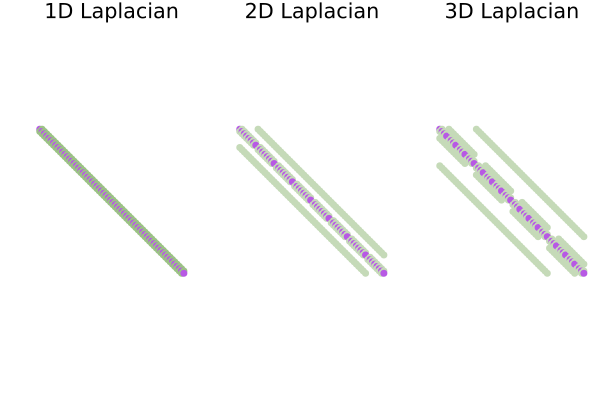

In [4]:
m = 4^3

L₁ = SymTridiagonal(2 * ones(m), -1 * ones(m-1))

p = bigspy(L₁, m=4, clim=(-2,2), colorbar=false, framestyle=:none, title="1D Laplacian")

m = 8

L₁ = SymTridiagonal(2 * ones(m), -1 * ones(m-1))
I₁ = Diagonal(ones(m))
L₂ = kron(L₁,I₁) + kron(I₁,L₁)
q = bigspy(L₂,clim=(-4,4), colorbar=false, framestyle=:none, title="2D Laplacian")

m = 4

L₁ = SymTridiagonal(2 * ones(m), -1 * ones(m-1))
I₁ = Diagonal(ones(m))
I₂ = Diagonal(ones(m*m))
L₂ = kron(L₁,I₁) + kron(I₁,L₁)
L₃ = kron(L₂,I₁) + kron(I₂,L₁)
r = bigspy(L₃,clim=(-4,4), colorbar=false, framestyle=:none, title="3D Laplacian")
#L₂ = kron(L₁,L₁)
#L₃ = kron(L₂,L₁)
plot(p,q,r,layout=(1,3))

- symmetric positive definite
- $L_d$ has at most $2d + 1$ nonzeros per row / column

In [5]:
function laplacian(d, m)
    if d == 1
        return SparseMatrixCSC(SymTridiagonal(2 * ones(m), -1 * ones(m-1)))
    elseif d > 1
        L₁ = laplacian(1, m)
        L = laplacian(d-1,m)
        Id = SparseMatrixCSC(Diagonal(ones(m^(d-1))))
        I₁ = SparseMatrixCSC(Diagonal(ones(m)))
        return SparseMatrixCSC(kron(L,I₁)) + SparseMatrixCSC(kron(Id, L₁))
    end
end;

In [6]:
ms = Int64.(round.(10 .^ LinRange(1, 4, 20)))
ts = Float64[]
for m in ms
    L₁ = Matrix(laplacian(1, m)) # dense
    b = randn(m)
    push!(ts, @elapsed L₁ \ b)
end

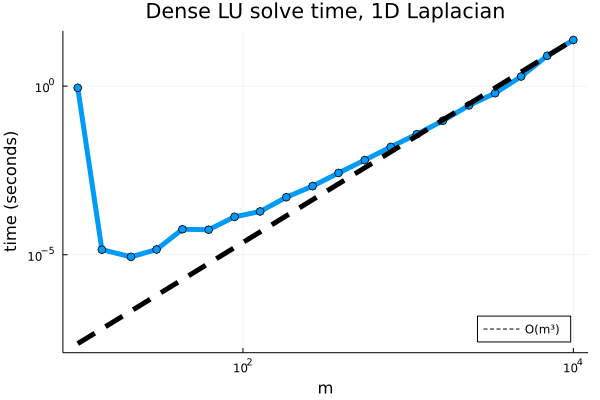

In [7]:
p = plot(ms, ts
    , xlabel = "m"
    , ylabel = "time (seconds)"
    , title = "Dense LU solve time, 1D Laplacian"
    , scale = :log10
    , m = :o
    , legend = :bottomright
)
plot!(p, [ms[1], ms[end]], [ts[end] .* (ms[1] / ms[end]) .^ 3 , ts[end]]
    , l = (:dash, :black)
    , label="O(m³)")

In [8]:
ms_2 = Int64.(round.(10 .^ LinRange(1, 7, 20)))
ts_2 = Float64[]
for m in ms_2
    L₁ = laplacian(1, m) # sparse
    b = randn(m)
    push!(ts_2, @elapsed L₁ \ b)
end

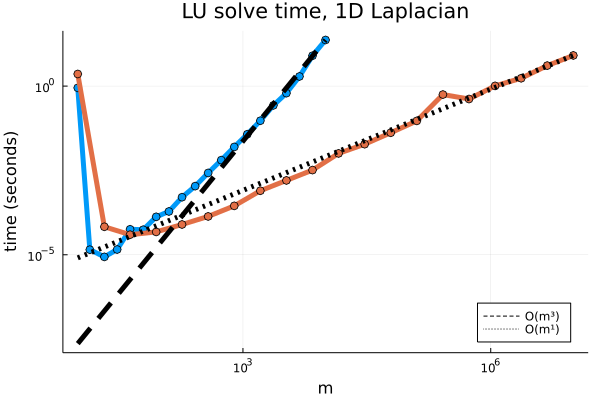

In [9]:
p = plot([ms ms_2], [ts ts_2]
    , xlabel = "m"
    , ylabel = "time (seconds)"
    , title = "LU solve time, 1D Laplacian"
    , scale = :log10
    , m = :o
    , legend = :bottomright
)
plot!(p, [ms[1], ms[end]], [ts[end] .* (ms[1] / ms[end]) .^ 3 , ts[end]]
    , l = (:dash, :black)
    , label="O(m³)")
plot!(p, [ms_2[1], ms_2[end]], [ts_2[end] .* (ms_2[1] / ms_2[end]) .^ 1 , ts_2[end]]
    , l = (:dot, :black)
    , label="O(m¹)")

In [10]:
ms_3 = Int64.(round.(10 .^ LinRange(1, 2, 20)))
Ms_3 = Float64[]
ts_3 = Float64[]
for m in ms_3
    L₂ = Matrix(laplacian(2, m)) # dense
    M = m * m
    push!(Ms_3, M)
    b = randn(M)
    push!(ts_3, @elapsed L₂ \ b)
end

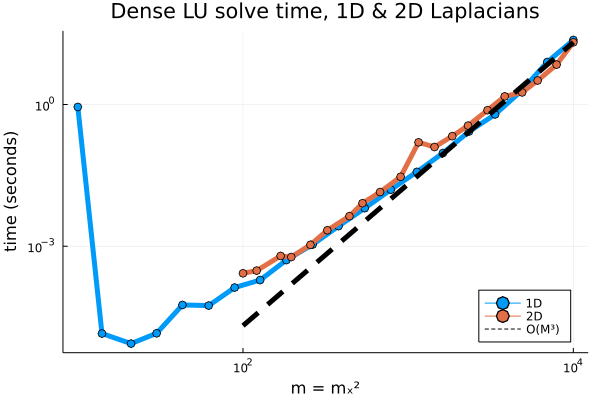

In [11]:
p = plot([ms Ms_3], [ts ts_3]
    , xlabel = "m = mₓ²"
    , ylabel = "time (seconds)"
    , title = "Dense LU solve time, 1D & 2D Laplacians"
    , scale = :log10
    , m = :o
    , label = ["1D" "2D"]
    , legend = :bottomright
)
plot!(p, [Ms_3[1], Ms_3[end]], [ts_3[end] .* (Ms_3[1] / Ms_3[end]) .^ 3 , ts_3[end]]
    , l = (:dash, :black)
    , label="O(M³)")

In [12]:
ms_4 = Int64.(round.(10 .^ LinRange(1, 3.3, 20)))
Ms_4 = Float64[]
ts_4 = Float64[]
for m in ms_4
    L₂ = laplacian(2, m) # sparse
    M = m * m
    push!(Ms_4, M)
    b = randn(M)
    push!(ts_4, @elapsed L₂ \ b)
end

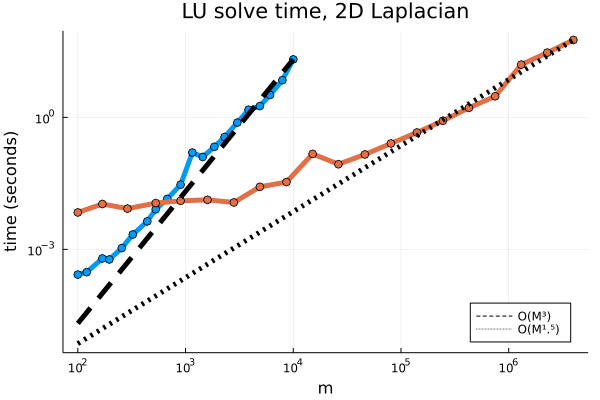

In [13]:
p = plot([Ms_3 Ms_4], [ts_3 ts_4]
    , xlabel = "m"
    , ylabel = "time (seconds)"
    , title = "LU solve time, 2D Laplacian"
    , scale = :log10
    , m = :o
    , legend = :bottomright
)
plot!(p, [Ms_3[1], Ms_3[end]], [ts_3[end] .* (Ms_3[1] / Ms_3[end]) .^ 3 , ts_3[end]]
    , l = (:dash, :black)
    , label="O(M³)")
plot!(p, [Ms_4[1], Ms_4[end]], [ts_4[end] .* (Ms_4[1] / Ms_4[end]) .^ 1.5 , ts_4[end]]
    , l = (:dot, :black)
    , label="O(M¹.⁵)")

In [14]:
ms_5 = collect(3:22)
Ms_5 = Float64[]
ts_5 = Float64[]
for m in ms_5
    L₃ = Matrix(laplacian(3, m)) # dense
    M = m * m * m
    push!(Ms_5, M)
    b = randn(M)
    push!(ts_5, @elapsed L₃ \ b)
end

In [15]:
ms_6 = collect(3:2:41)
Ms_6 = Float64[]
ts_6 = Float64[]
for m in ms_6
    L₃ = laplacian(3, m) # sparse
    M = m * m * m
    push!(Ms_6, M)
    b = randn(M)
    push!(ts_6, @elapsed L₃ \ b)
end

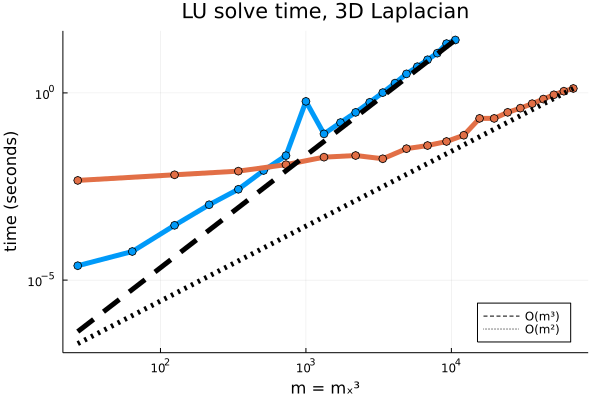

In [16]:
p = plot([Ms_5 Ms_6], [ts_5 ts_6]
    , xlabel = "m = mₓ³"
    , ylabel = "time (seconds)"
    , title = "LU solve time, 3D Laplacian"
    , scale = :log10
    , m = :o
    , legend = :bottomright
)
plot!(p, [Ms_5[1], Ms_5[end]], [ts_5[end] .* (Ms_5[1] / Ms_5[end]) .^ 3 , ts_5[end]]
    , l = (:dash, :black)
    , label="O(m³)")
plot!(p, [Ms_6[1], Ms_6[end]], [ts_6[end] .* (Ms_6[1] / Ms_6[end]) .^ 2 , ts_6[end]]
    , l = (:dot, :black)
    , label="O(m²)")

### Conclusion

- Sparse direct performance depends not just on the sparsity of $A$ but on the sparsity of the computed factors

### More complicated improvement: application specific algorithms

Applications that generate matrices can develop algorithms that depend on more structure than just sparsity

**Example:** there are $O(m[\log m])$ solvers for the Laplacian and related discretized PDEs

In [17]:
import FFTW

function inverse_laplacian(d, b)
    y = copy(b)
    M = length(b)
    m = Int64(round(M^(1/d)))
    dims = repeat([m],d)
    y = reshape(y, dims...)
    kinds = repeat([FFTW.RODFT00],d)
    ϕ = π / (m + 1)
    λs = [2 * (1 - cos(k * ϕ)) for k in 1:m]
    inds = [reshape(repeat(λs, inner=m^(k-1), outer=m^(d-k)), dims...) for k in 1:d]
    factor = sum(inds)
    sqs = collect(1:m)
    sqs .*= sqs
    sqs = kron(sqs, ones(m))
    FFTW.r2r!(y, kinds)
    y ./= factor * (2 * (m+1))^d
    FFTW.r2r!(y, kinds)
    return reshape(y, M)
end

inverse_laplacian (generic function with 1 method)

In [18]:
ms_7 = Int64.(round.(3 .^ LinRange(1, 4,20)))
Ms_7 = Float64[]
ts_7 = Float64[]
for m in ms_7
    L₃ = laplacian(3, m) # sparse
    M = m * m * m
    push!(Ms_7, M)
    b = randn(M)
    push!(ts_7, @elapsed inverse_laplacian(3, b))
end

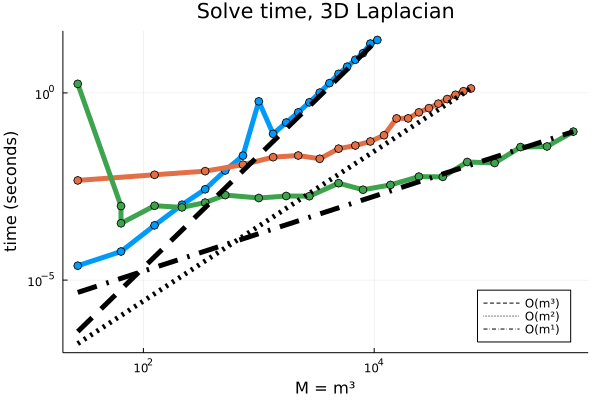

In [19]:
p = plot([Ms_5 Ms_6 Ms_7], [ts_5 ts_6 ts_7]
    , xlabel = "M = m³"
    , ylabel = "time (seconds)"
    , title = "Solve time, 3D Laplacian"
    , scale = :log10
    , m = :o
    , legend = :bottomright
)
plot!(p, [Ms_5[1], Ms_5[end]], [ts_5[end] .* (Ms_5[1] / Ms_5[end]) .^ 3 , ts_5[end]]
    , l = (:dash, :black)
    , label="O(m³)")
plot!(p, [Ms_6[1], Ms_6[end]], [ts_6[end] .* (Ms_6[1] / Ms_6[end]) .^ 2 , ts_6[end]]
    , l = (:dot, :black)
    , label="O(m²)")
plot!(p, [Ms_7[1], Ms_7[end]], [ts_7[end] .* (Ms_7[1] / Ms_7[end]) .^ 1 , ts_7[end]]
    , l = (:dashdot, :black)
    , label="O(m¹)")

### Between dense, sparse, and application specific

**Aim:** methods for solving

$$\large Ax = b$$

that are better than dense / sparse direct methods for many problems, but without using too many application-specific details

**Observation:** Many applications, because of their structure, have **fast matrix-vector products:**

$$\large T_{\text{matvec}}(A) = o(m^2)$$

and for many applications,

$$\large T_{\text{matvec}}(A) = O(m)$$

### Fast matvec example: discrete Laplacian

$$\large T_{\text{matvec}}(L_d) = O(d(m_x)^d) = O(d m) = o(m^2)$$

### Example: general sparse matrix

If $A$ has $n_{\text{nnz}}$ nonzeros, then

$$\large T_{\text{matvec}}(A) = O(n_{\text{nnz}})$$

### Linear operator AKA "black-box" methods

If the only computational kernel available to us about a ~~matrix~~ linear operator is its action on a vector,

$$\large A: x \mapsto Ax,$$

then we need a **black box algorithm** that can solve $Ax = b$ relying only on this operation

### Exercise: simplest bound

**Claim:** $m T_{\text{matvec}}(A) + O(m^3)$ is an upper bound on the complexity of solving $Ax = b.$

_Proof._

## Example: Richardson Iteration

$$\begin{aligned}
x^{(0)} &\gets 0 \\
r^{(k)} &\gets b - A x^{(k)} \\
x^{(k+1)} &\gets x^{(k)} + \alpha r^{(k)}
\end{aligned}
$$

- $x^{(k)}$: the approximate solution after $k$ steps

- $r^{(k)}$: the **residual** after $k$ steps

### Relate $r^{(k+1)}$ to $r^{(k)}$: the iteration matrix

Unroll a little more:

$$\begin{aligned}
x^{(0)} &\gets 0 \\
r^{(k)} &\gets b - A x^{(k)} \\
x^{(k+1)} &\gets x^{(k)} + \alpha r^{(k)} \\
r^{(k+1)} &\gets b - A x^{(k+1)} \\
\end{aligned}
$$

Substite the third line in the fourth:

$$\begin{aligned}
x^{(0)} &\gets 0 \\
r^{(k)} &\gets b - A x^{(k)} \\
x^{(k+1)} &\gets x^{(k)} + \alpha r^{(k)} \\
r^{(k+1)} &\gets b - A (x^{(k)} + \alpha r^{(k)}) \\
&\phantom{\gets} = \underbrace{b - A x^{(k)}}_{r^{(k)}} - \alpha A r^{(k)}
\end{aligned}
$$

$$\large r^{(k+1)} = \underbrace{(I - \alpha A)}_{\text{iteration matrix}} r^{(k)} = (I - \alpha A)^{k+1} \underbrace{r^{(0)}}_{b}.$$

### Sufficient condition for convergence

**Claim.** If $\rho = \max_{\lambda \in \Lambda(I - \alpha A)} |\lambda| < 1$, then $r^{(k)} \to 0$, and

$$\Large \|r^{(k)}\| = O(\rho^k \|b\|)$$

### Example: convergence of Richardson for the Laplacian

In [20]:
@views function richardson!(x, A, b, α, n_iter)
    r = copy(b)
    axpby!(α, r, 0.0, x) 
    for k in 1:(n_iter-1)
        axpby!(1.0, b, 0.0, r)
        mul!(r,A,x,-1.0,1.0)
        axpy!(α, r, x)
    end
    return nothing
end

richardson! (generic function with 1 method)

In [21]:
d = 3
m = 10
L₃ = laplacian(d, m)
b = randn(m^3)
M = Matrix(L₃)
x_dense = copy(b)
t_dense = @elapsed M \ b
r_dense = norm(b - L₃ * (M \ b))
t_sparse = @elapsed L₃ \ b
r_sparse = norm(b - L₃ * (L₃ \ b))

1.423994672390564e-14

In [22]:
d = 3
m = 10
t_fft = @elapsed inverse_laplacian(d, b)
r_fft = norm(b - L₃ * inverse_laplacian(d, b));

In [23]:
t_rich = Float64[]
r_rich = Float64[]
for n_iter in 1:2000
    x = zeros(m^3)
    push!(t_rich, @elapsed richardson!(x, L₃, b, 0.5 / d, n_iter))
    push!(r_rich, norm(b - L₃ * x))
end
t_rich = accumulate(min, t_rich[end:-1:1])[end:-1:1];

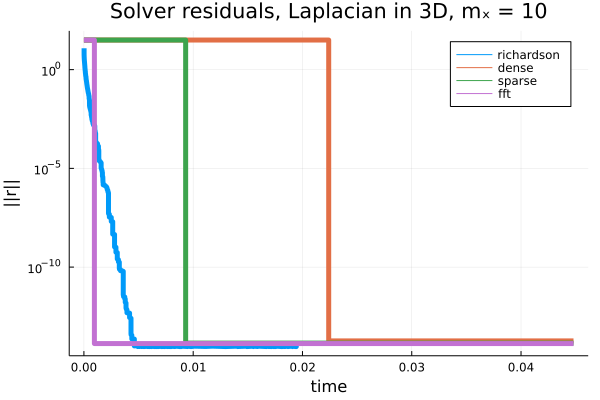

In [24]:
p = plot(t_rich, r_rich, yscale=:log10, label="richardson", xlabel="time", ylabel="||r||", title = "Solver residuals, Laplacian in 3D, mₓ = $m")
plot!(p, [0, t_dense, t_dense, 2 * t_dense], [norm(b), norm(b), r_dense ,r_dense], label="dense")
plot!(p, [0, t_sparse, t_sparse, 2 * t_dense], [norm(b), norm(b), r_sparse ,r_sparse], label="sparse")
plot!(p, [0, t_fft, t_fft, 2 * t_dense], [norm(b), norm(b), r_fft ,r_fft], label="fft")

In [25]:
d = 3
m = 20
L₃ = laplacian(d, m)
b = randn(m^3)
M = Matrix(L₃)
t_fft = @elapsed inverse_laplacian(d, b)
r_fft = norm(b - L₃ * inverse_laplacian(d, b));

In [26]:
t_rich = Float64[]
r_rich = Float64[]
for n_iter in 1:2000
    x = zeros(m^3)
    push!(t_rich, @elapsed richardson!(x, L₃, b, 0.5 / d, n_iter))
    push!(r_rich, norm(b - L₃ * x))
end
t_rich = accumulate(min, t_rich[end:-1:1])[end:-1:1];

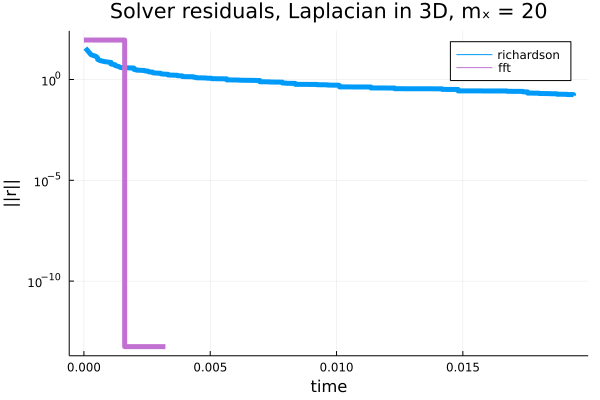

In [27]:
r_rich = r_rich[1:200]
t_rich = t_rich[1:200]
p = plot(t_rich, r_rich, yscale=:log10, label="richardson", xlabel="time", ylabel="||r||", title = "Solver residuals, Laplacian in 3D, mₓ = $m")
plot!(p, [0, t_fft, t_fft, 2 * t_fft], [norm(b), norm(b), r_fft ,r_fft], label="fft", c = 4)

### Observations about Richardson for the Laplacian (about all iterative methods)

- Whether Richardson is better than other methods depends on how small you want the norm of the residual to be

- How well Richardson works depends on $m_x$: why?

### Convergence behavior and eigenvalues

Suppose $A$ is diagonalizable and expand $b$ in the eigenbasis,

$$\large b = \sum_j v_j$$

Then $r^{(k)} = (I - \alpha A)^k b$ implies

$$\large r^{(k)} = \sum_{j} (1 - \alpha \lambda_j)^k v_j.$$

In [28]:
α = 1/6
ρs = [eigmax(Matrix(I - α * laplacian(3, m))) for m in ms_5];

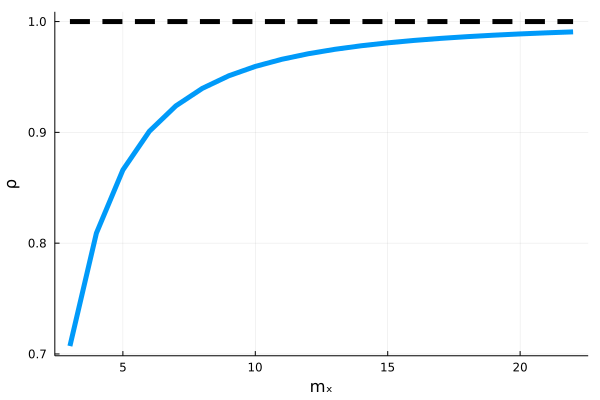

In [29]:
p = plot(ms_5, ρs, xlabel="mₓ", ylabel="ρ")
plot!(p, ms_5[[1,end]], [1,1], l=(:dash, :black))

### The iteration polynomial for Richardson

Let

$$\large p_k(x) = (1 - \alpha x)^k.$$

Then

$$\large r^{(k)} = \sum_{j} p_k(\lambda_j) v_j.$$

We can see the iteration polynomial without expanding $b$ in the eigenbasis:

$$\large r^{(k)} = p_k(A) b.$$

### Polynomials and black box iterations

When designing iterative algorithms that only use the matvec kernel, the goal is to make

$$\|\large p_k(A) b\|$$

as small as possible (where $p_k$ is the iteration polynomial of the algorithm).

## Krylov subspaces

The **Krylov subspace** $K_n(A, b)$ is

$$\large K_n(A, b) = \{b, Ab, A^2 b, \dots, A^{n-1} b\}$$



A **Krylov subspace method** seeks an approximate solution $\tilde{x}$  to $Ax = b$ in $K_n(A,b)$ for some $n$

### Exercise

Let $A \in \mathbb{C}^{m \times m}$ and $b \in \mathbb{C}^m$ be arbitrary.  Show that any $x \in K_n$ is equal to $p(A)b$ for some polynomial $p$ of degree $\leq n - 1$.

*Proof.* From definition,
$$x \in K_n=\mathrm{span}\{b,Ab,\cdots,A^{n-1}b\}\Rightarrow x=\sum_{i=0}^{n-1}k_iA^ib\in p(A)b$$

Because Krylov subspaces are nested, and because only one matvec is needed to grow a basis for $K_n(A,b)$ into a basis for $K_{n+1}(A,b)$, Krylov subspace methods are a useful class of black-box iterative algoritms.

### The conditioning of the literal Krylov basis

In [30]:
function K(n, A, b)
    if n == 1
        return [copy(b);;]
    else
        Ks = K(n-1, A, b)
        return [Ks A*Ks[:,end]]
    end
end

K (generic function with 1 method)

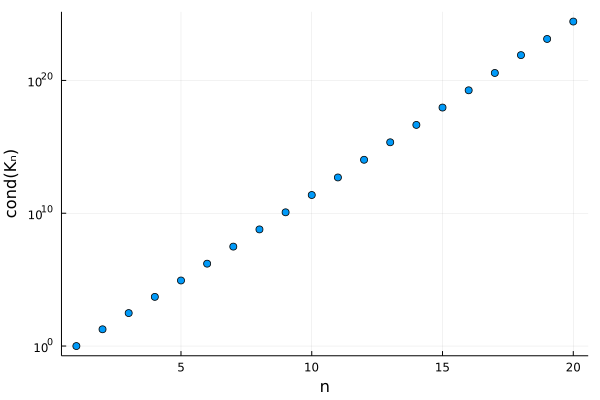

In [31]:
d = 3
m = 10
n = 20
A = laplacian(d, m)
b = randn(m^d)
conds = [cond(K(k, A, b)) for k in 1:20];
plot(1:20,conds,xlabel="n", ylabel="cond(Kₙ)", yscale=:log10, st=:scatter)